In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import time
import sys
import numba
import pickle

In [2]:
symbols = ['AUDUSD=X','EURUSD=X','GBPUSD=X','USDCAD=X','NZDUSD=X','USDJPY=X']
all_data = dict()
for symbol in symbols:
  all_data[symbol] = np.log(yf.download(symbol).Close)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Evaluation

In [3]:
import pandas_datareader as pdr
import statsmodels.api as sm
class Evaluator():
  from datetime import datetime as dt
  from scipy.stats import t

  ff3_reader = pdr.famafrench.FamaFrenchReader('F-F_Research_Data_Factors_daily',start='1900-01-01',end=str(dt.today()))
  ff3 = ff3_reader.read()[0]/100
  ff3_reader.close()

  mom_reader = pdr.famafrench.FamaFrenchReader('F-F_Momentum_Factor_daily',start='1900-01-01',end=str(dt.today()))
  mom = mom_reader.read()[0]/100
  mom_reader.close()

  fourFactor = pd.concat([ff3,mom],axis=1)
  def __init__(self,returns):
    self.set_returns(returns)
    self.set_fourFactor()
  def set_fourFactor(self):
    self.fourFactor['Strategy-RF'] = self.returns - self.fourFactor['RF']
    self.fourFactor.dropna(inplace=True)
  def set_returns(self,returns):
    self.returns = returns.copy()
  def reset_summary(self):
    self.summary = pd.DataFrame()
  def get_summary(self):
    self.reset_summary()
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')
    summary = pd.DataFrame()
    summary.loc['CAGR',['Value','Sample size']] = self.get_CAGR()
    summary.loc['Mean',['Value','Sample size']] = self.get_mean()
    summary.loc['Vol',['Value','Sample size']] = self.get_vol()
    summary.loc['SR',['Value','Sample size','P-value']] = self.get_sharpeRatio()
    summary.loc['CAPM Alpha',['Value','Sample size','P-value']] = self.get_CAPMAlpha()
    summary.loc['Carhart Alpha',['Value','Sample size','P-value']] = self.get_CarhartAlpha()
    summary.loc['Beta',['Value','Sample size','P-value']] = self.get_beta()
    summary.loc['Skew',['Value','Sample size']] = self.get_skew()
    summary.loc['Skew (M)',['Value','Sample size']] = self.get_monthlySkew()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Avg Drawdown',['Value','Sample size']] = self.get_avgDrawdown()
    summary.loc['Max Drawdown',['Value','Sample size']] = self.get_maxDrawdown()
    summary.loc['Kurt',['Value','Sample size']] = self.get_kurt()
    summary.loc['Downside Risk',['Value','Sample size']] = self.get_downsideRisk()
    summary.loc['VaR 95%',['Value','Sample size']] = self.get_VaR(0.95)
    summary.loc['Exp Shortfall 95%',['Value','Sample size']] = self.get_expectedShortfall(0.95)
    summary.loc['VaR 99%',['Value','Sample size']] = self.get_VaR(0.99)
    summary.loc['Exp Shortfall 99%',['Value','Sample size']] = self.get_expectedShortfall(0.99)
    self.summary = summary
    return self.summary
  def get_cumsum(self):
    cumsum = self.returns.cumsum()
    return cumsum
  def get_cumprod(self):
    cumprod = (1+self.returns).cumprod()
    return cumprod
  def get_cumRet(self):
    cumprod = self.get_cumprod()[-1]
    cumRet = cumprod-1
    sampleSize = cumprod.size
    return cumRet,sampleSize
  def get_CAGR(self):
    cumprod= self.get_cumprod()
    cumRet,sampleSize = cumprod[-1],cumprod.size
    years = sampleSize/252
    CAGR = cumRet**(1/years)-1
    print(cumRet,(1/years))
    return CAGR,sampleSize
  def get_CAPMAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_beta(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    beta = result.params[1]
    p = result.pvalues[1]
    return beta,sampleSize,p
  def get_CarhartAlpha(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    sampleSize = Y.size
    model = sm.OLS(Y,X)
    result = model.fit()
    alpha = result.params[0]*252
    p = result.pvalues[0]
    return alpha,sampleSize,p
  def get_CAPMSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor['Mkt-RF'])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_CarhartSummary(self):
    Y = self.fourFactor['Strategy-RF']
    X = sm.add_constant(self.fourFactor[['Mkt-RF','SMB','HML','Mom   ']])
    model = sm.OLS(Y,X)
    result = model.fit()
    return result.summary()
  def get_factorCorr(self):
    return self.fourFactor.corr()
  def get_mean(self):
    mean = self.returns.mean()*252
    sampleSize = self.returns.size
    return mean,sampleSize
  def get_vol(self):
    vol = self.returns.std()*np.sqrt(252)
    sampleSize = self.returns.size
    return vol,sampleSize
  def get_sharpeRatio(self):
    sharpeRatio = self.get_mean()[0]/self.get_vol()[0]
    sampleSize = self.returns.size

    t_stat = sharpeRatio * np.sqrt(sampleSize)
    # p-value for 2-sided test
    p_2sided = 2*(1 - Evaluator.t.cdf(abs(t_stat), sampleSize))

    return sharpeRatio,sampleSize,p_2sided
  def get_monthlyReturns(self):
    monthlyReturns = self.returns.resample('M').sum()
    return monthlyReturns
  def get_monthlySkew(self):
    monthlyReturns = self.get_monthlyReturns()
    monthlySkew = monthlyReturns.skew()
    sampleSize = monthlyReturns.size
    return monthlySkew,sampleSize
  def get_skew(self):
    skew = self.returns.skew()
    sampleSize = self.returns.size
    return skew,sampleSize
  def get_kurt(self):
    kurt = self.returns.kurt()
    sampleSize = self.returns.size
    return kurt,sampleSize
  def get_downsideRisk(self,requiredReturn=0):
    downside = requiredReturn-self.returns
    downside[downside>0] = 0
    downsideRisk = np.sqrt((downside**2).mean())*np.sqrt(252)
    sampleSize = downside[downside<0].size
    return downsideRisk,sampleSize
  def get_VaR(self,confidence=0.99):
    VaR = self.returns.quantile(q=(1-confidence))
    sampleSize = self.returns.size
    return VaR,sampleSize
  def get_expectedShortfall(self,confidence=0.99):
    VaR = self.get_VaR(confidence)[0]
    shortfall = self.returns[self.returns<VaR]
    expectedShortfall = shortfall.mean()
    sampleSize = shortfall.size
    return expectedShortfall,sampleSize
  def get_drawdowns(self):
    cumprod = self.get_cumprod()
    drawdowns = cumprod - cumprod.expanding().max()
    drawdowns = drawdowns[drawdowns<0]
    return drawdowns
  def get_maxDrawdown(self):
    maxDrawdown = self.get_drawdowns().min()
    sampleSize = 1
    return maxDrawdown,sampleSize
  def get_avgDrawdown(self):
    drawdowns = self.get_drawdowns()
    avgDrawdown = drawdowns.mean()
    sampleSize = drawdowns.size
    return avgDrawdown,sampleSize

# Features

In [4]:
def de_lag(feat,lookback=20):
  delag = feat - feat.shift(lookback)
  return delag
def de_mean(feat,lookback=120):
  demean = feat - feat.rolling(lookback).mean()
  return demean
def de_med(feat,lookback=120):
  demean = feat - feat.rolling(lookback).median()
  return demean
def de_std(feat,lookback=120):
  devar = feat / feat.rolling(lookback).std()
  return devar
def de_iqr(feat,lookback=120):
  devar = feat / (feat.rolling(lookback).quantile(0.75) - feat.rolling(lookback).quantile(0.25))
  return devar
def tr_root(feat,deg=2):
  if deg == 2:
    trroot = pd.Series(np.sqrt(feat) , index=feat.index)
  elif deg == 3:
    trroot = pd.Series(np.cbrt(feat) , index=feat.index)
  return trroot
def tr_log(feat):
  trlog = np.log(feat)
  return trlog
def log_tail(feat,lookback=120,threshold=0.05):
  feat = feat.copy()
  ltail = feat.rolling(lookback).quantile(threshold)
  utail = feat.rolling(lookback).quantile(1-threshold)
  #feat.loc[feat < ltail] = ltail + np.log(feat.loc[feat < ltail] / ltail)
  feat.loc[feat > utail] = utail + np.log(feat.loc[feat > utail] / utail)
  return feat
def logistic(feat):
  denom = 1 + np.exp(-feat)
  logistic = 1 / denom
  return logistic

In [10]:
from scipy.stats import linregress
def get_slope(logprc):
  y,x = logprc,range(1,1+logprc.shape[0])
  slope = linregress(x,y)[0]
  return slope
def get_r2(logprc):
  y,x = logprc,range(1,1+logprc.shape[0])
  r2 = linregress(x,y)[2]**2
  return r2
def get_vol(logprc):
  vol = logprc.diff().std()
  return vol
def get_rsi(logprc):
  logret = logprc.diff()
  gain = logret[logret>0].sum()
  loss = logret[logret<0].sum()
  rsi = 100 - 100/(1-gain/loss)
  return rsi

In [11]:
def get_feat(logprc,lookback):
  slope_0 = logprc.rolling(lookback).apply(get_slope)
  slope_1 = logprc.rolling(lookback//2).apply(get_slope)
  slope_2 = logprc.rolling(lookback*2).apply(get_slope)
  r2_0 = logprc.rolling(lookback).apply(get_r2)
  r2_1 = logprc.rolling(lookback//2).apply(get_r2)
  r2_2 = logprc.rolling(lookback*2).apply(get_r2)
  ema_0 = logprc.ewm(lookback).mean() - logprc.ewm(lookback*4).mean()
  ema_1 = logprc.ewm(lookback//2).mean() - logprc.ewm(lookback*4//2).mean()
  ema_2 = logprc.ewm(lookback*2).mean() - logprc.ewm(lookback*4*2).mean()
  vol_0 = logprc.rolling(lookback).apply(get_vol)
  vol_1 = logprc.rolling(lookback//2).apply(get_vol)
  vol_2 = logprc.rolling(lookback*2).apply(get_vol)
  rsi_0 = logprc.rolling(lookback).apply(get_rsi)
  rsi_1 = logprc.rolling(lookback//2).apply(get_rsi)
  rsi_2 = logprc.rolling(lookback*2).apply(get_rsi)

  feat = pd.DataFrame({'SLOPE_0':slope_0,
                       'SLOPE_1':slope_1,
                       'SLOPE_2':slope_2,
                       'R2_0':r2_0,
                       'R2_1':r2_1,
                       'R2_2':r2_2,
                       'SLOPE_R2_0':slope_0*r2_0,
                       'SLOPE_R2_1':slope_1*r2_1,
                       'SLOPE_R2_2':slope_2*r2_2,
                       'EMA_0':ema_0,
                       'EMA_1':ema_1,
                       'EMA_2':ema_2,
                       'VOL_0':vol_0,
                       'VOL_1':vol_1,
                       'VOL_2':vol_2,
                       'RSI_0':rsi_0,
                       'RSI_1':rsi_1,
                       'RSI_2':rsi_2})
  return feat

# Trend Detection Label

In [12]:
def get_label(logprc,window=None,tp=None,sl=None,hd=None):
  logret = logprc.diff().shift(-1)
  vol = logret.rolling(60).std()

  if tp is None or sl is None or hd is None:
    tp = window ** 0.5
    sl = window ** 0.5
    hd = window

  print(tp , sl , hd)
  label = []

  for i,ret in logret.items():
    up_bar = vol.loc[i] * tp
    low_bar = vol.loc[i] * -sl
    horzn_bar = hd

    future_ret = logret.loc[i:]
    cum_ret = ret
    cum_day = 1
    while True:
      if cum_ret >= up_bar:
        label.append(1)
        break
      elif cum_ret <= low_bar:
        label.append(-1)
        break
      elif cum_day >= horzn_bar or cum_day >= future_ret.shape[0]:
        label.append(0)
        break

      ret = future_ret[cum_day]
      cum_day += 1
      cum_ret += ret

  label = pd.Series(label , index=logret.index , name='LABEL')
  return label

In [13]:
all_dataset = dict()
for symbol in symbols:
  data = all_data[symbol]
  feat = get_feat(data,20)
  label = get_label(data,tp=2,sl=2,hd=20)
  dataset = pd.concat([label,feat],axis=1).dropna()
  all_dataset[symbol] = dataset

2 2 20
2 2 20
2 2 20
2 2 20
2 2 20
2 2 20


In [14]:
cum_ret = data.diff().shift(-1).cumsum()
vol = data.diff().rolling(20).std()

up_bar = 4.47 * vol
low_bar = 4.47 * vol
horzn_bar = 5

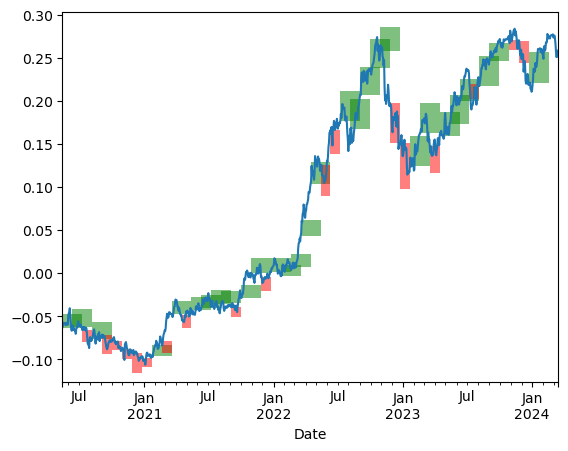

In [31]:
from matplotlib.patches import Rectangle

period = cum_ret.index[-1000:]
dates = cum_ret.loc[period].index

sub_label = label.loc[period][::horzn_bar]
sub_cum_ret = cum_ret.loc[period]

ax = sub_cum_ret.plot()

for i,lab in enumerate(sub_label):
  if i+2 >= len(sub_label): break

  if lab == 1:
    w = sub_label.index[i+2] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]]

    rect = Rectangle((x,y),w,h,
                     facecolor='g',alpha=0.5)
    ax.add_patch(rect)
  elif lab == -1:
    w = sub_label.index[i+1] - sub_label.index[i]
    h = up_bar.loc[sub_label.index[i]]
    x = sub_label.index[i]
    y = sub_cum_ret[sub_label.index[i]] - h

    rect = Rectangle((x,y),w,h,
                     facecolor='r',alpha=0.5)
    ax.add_patch(rect)


# Random Forest Prediction

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression,ElasticNet

In [63]:
train_size = 1000
step = 20

all_rf_pred = dict()
all_rf_prob = dict()
big_dataset = pd.concat(all_dataset.values(),axis=0)

for symbol in symbols:
  print(symbol)
  rf_pred_list = []
  rf_prob_list = []

  dataset = all_dataset[symbol]
  for start in range(train_size , len(dataset) , step):
    train_set = dataset.iloc[start - train_size : start]
    #train_set = dataset.iloc[ : start].loc[train_set.index]
    #big_train_set = big_dataset.loc[train_set.index]
    test_set = dataset.iloc[start : start + step]

    #big_train_y , big_train_x = big_train_set['LABEL'] , big_train_set.drop(columns='LABEL')
    train_y , train_x = train_set['LABEL'] , train_set.drop(columns='LABEL')
    test_x = test_set.drop(columns='LABEL')

    #print(f'[{test_x.index[0].date()}]' , end=' ')
    #if start%100 == 0: print()
    #sys.stdout.flush()

    rf = RandomForestClassifier(random_state=300300,
                                n_estimators=500,
                                max_depth=3)
    rf.fit(X=train_x , y=train_y)
    #rf.fit(X=big_train_x , y=big_train_y)
    rf_pred_list.append(pd.Series(rf.predict(X=test_x) , index=test_x.index))
    rf_prob_list.append(pd.DataFrame(rf.predict_proba(X=test_x) , index=test_x.index))

  rf_pred = pd.concat(rf_pred_list)
  rf_prob = pd.concat(rf_prob_list)
  all_rf_pred[symbol] = rf_pred
  all_rf_prob[symbol] = rf_prob

AUDUSD=X


In [19]:
def get_pos(pred,prob):
  l = np.where(pred == 1 , 1 * prob.iloc[:,2] , 0)
  s = np.where(pred == -1 , -1 * prob.iloc[:,0] , 0)
  pos = pd.Series(l + s , index=pred.index)
  return pos

In [22]:
def scale_vol(pnl):
  vol = pnl.std()
  scalar = .20 / 16 / vol
  scaled_pnl = pnl * scalar
  return scaled_pnl

In [21]:
probpos = get_pos(all_rf_pred['AUDUSD=X'],all_rf_prob['AUDUSD=X'])

In [ ]:
def get_pnl(pos,prob,logret,window=None,tp=None,sl=None,hd=None):
  #logret = logprc.diff().shift(-1)
  vol = logret.rolling(60).std()

  if tp is None or sl is None or hd is None:
    tp = window ** 0.5
    sl = window ** 0.5
    hd = window

  print(tp , sl , hd)
  pnl = []
  in_pos = False
  
  for i,p in pos.items():
    ret = logret.loc[i]
    if not in_pos and p!=0 and prob.loc[i,p+1]>=0.5:
      up_bar = vol.loc[i] * tp
      low_bar = vol.loc[i] * -sl
      horzn_bar = hd

      cum_ret = p * ret
      cum_day = 1
      pnl.append(p * ret)
    elif in_pos:
      cum_ret += p * ret
      cum_day += 1
      pnl.append(p * ret)
      
      if cum_ret >= up_bar or cum_ret <= low_bar or cum_day >= horzn_bar or prob.loc[i,p+1]<0.5:
        in_pos = False
    else:
      pnl.append(0)

  pnl = pd.Series(pnl , index=pos.index , name='LABEL')
  return pnl

In [ ]:
all_rf_pred['AUDUSD=X'] 

Date
2010-05-18    1
2010-05-19    1
2010-05-20    1
2010-05-21    1
2010-05-24    1
             ..
2024-03-08    1
2024-03-11    1
2024-03-12    1
2024-03-13    1
2024-03-14    1
Length: 3602, dtype: int64

2 2 20


<Axes: xlabel='Date'>

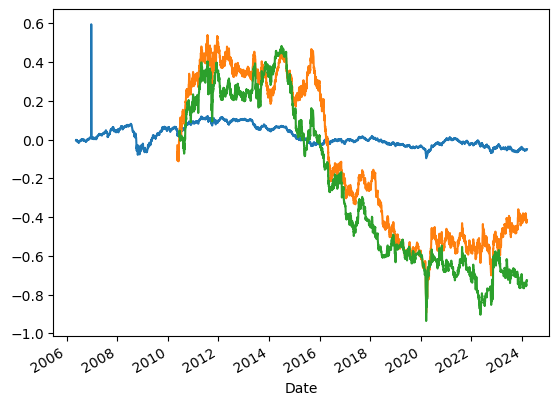

In [62]:
logret = all_data['AUDUSD=X'].diff().shift(-1)
pnl = get_pnl(all_rf_pred['AUDUSD=X'] , all_rf_prob['AUDUSD=X'] , logret , tp=2 , sl=2 , hd=20)
prob_pnl = probpos.rolling(20).mean() * logret

scale_vol(logret).cumsum().plot()
scale_vol(pnl).cumsum().plot()
scale_vol(prob_pnl).cumsum().plot()

In [ ]:
with open('all_rf_pred.pickle', 'wb') as handle:
    pickle.dump(all_rf_pred, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_pred.pickle "drive/My Drive/"

with open('all_rf_prob.pickle', 'wb') as handle:
    pickle.dump(all_rf_prob, handle, protocol=pickle.HIGHEST_PROTOCOL)
#!cp all_rf_prob.pickle "drive/My Drive/"

In [ ]:
with open('all_rf_pred.pickle', 'rb') as handle:
    all_rf_pred = pickle.load(handle)

with open('all_rf_prob.pickle', 'rb') as handle:
    all_rf_prob = pickle.load(handle)

In [ ]:
all_rf_pred

{}

Elapsed time to compute the importances: 20.575 seconds


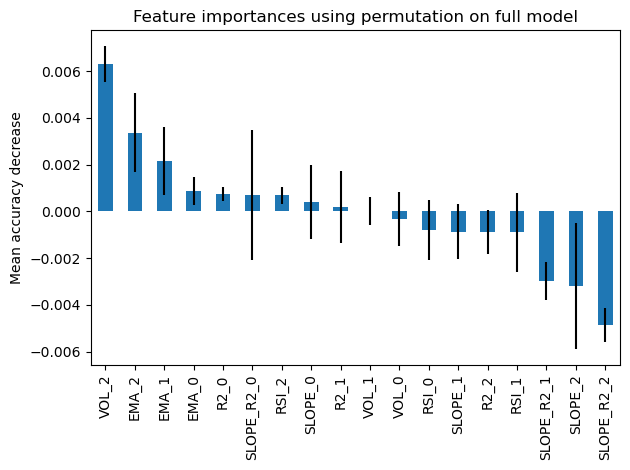

In [25]:
from sklearn.inspection import permutation_importance

start_time = time.time()
feature_names = test_x.columns
result = permutation_importance(
    rf, big_train_x, big_train_y, n_repeats=10, random_state=300300, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
mac_pred = data.ewm(20).mean() - data.ewm(80).mean()

In [ ]:
thr = 0.3
mac_pos = pd.Series(np.where(mac_pred > 0 , 1 , -1) , index=mac_pred.index)
rf_pos = rf_pred.copy().rolling(20).mean()

In [ ]:
logret = data.diff().shift(-1)

mac_pnl = mac_pos * logret
rf_pnl = rf_pos * logret

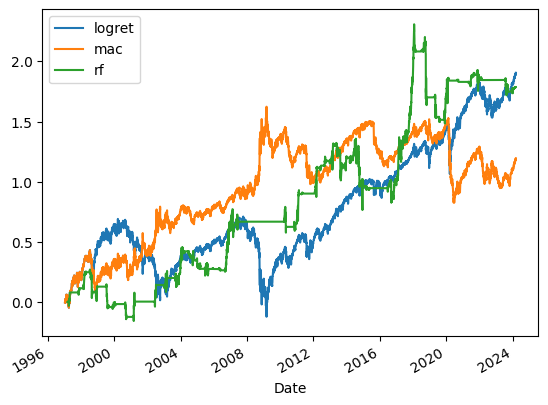

In [ ]:
period = data.index[1000:]

logret.loc[period].cumsum().plot()
mac_pnl.loc[period].cumsum().plot()
(rf_pnl.loc[period]*7).cumsum().plot()

plt.legend(['logret','mac','rf'])

In [ ]:
e = Evaluator(rf_pnl*7)
e.get_summary()

nan 0.03215926493108729


,Value,Sample size,P-value
CAGR,NaN,7836.0000,NaN
Mean,0.0662,7836.0000,NaN
Vol,0.2145,7836.0000,NaN
SR,0.3089,7836.0000,0.0000
CAPM Alpha,0.1774,2419.0000,0.1261
Carhart Alpha,0.1825,2419.0000,0.1175
Beta,-0.1306,2419.0000,0.0136
Skew,-1.9325,7836.0000,NaN
Skew (M),-0.3640,375.0000,NaN
Kurt,38.4076,7836.0000,NaN
